In [7]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to see how **Information Leakage** skews the evaluation of models .
4. I kept the filtering method `adult_filter` from the previous lecture


In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)

def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [4]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
### groups now contain information about SEX and RAC1P
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [5]:
# Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm', 
                        "RAC1P_White alone" ], axis = 1) 

### 2. Model with a proper normalisation
1. Split Train data into 100 different splits 
2. Train and evaluate model on each of these splits (aka use Cross validation to do so).
    * Use your favourite performance evaluation method.
3. Remember to **normalise data within the fold**.
4. Plot the distribution of performance scores:
    * What is the mean and standard deviation of the distribution?

[Text(0.5, 0, 'Accuracy'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'mean: 0.82, std: 0.02')]

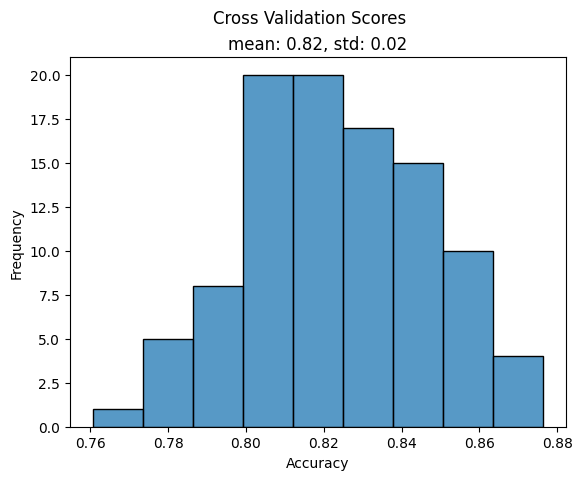

In [22]:
#######
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)
scaler = StandardScaler()

Log_reg = LogisticRegression()

log_pipeline = Pipeline([
    ('scaler', scaler),
    ('og_reg', Log_reg)
])

log_pipeline.fit(X_train, y_train.values.ravel())

cross_scores = cross_val_score(log_pipeline, X_test, y_test.values.ravel(), cv=100, scoring='accuracy')


hist = sns.histplot(cross_scores)
hist.figure.suptitle("Cross Validation Scores")
hist.set(xlabel='Accuracy', ylabel='Frequency', 
         title='mean: {:.2f}, std: {:.2f}'.format(np.mean(cross_scores), np.std(cross_scores)))
#######

### 3. Model with a WRONG normalisation
1. **Normalise data**
2. Split Train data into 100 different splits 
2. Train adn evaluate model on each of these splits (aka use Cross validation to do so).
    * Use your favourite performance evaluation method.
4. Plot the distribution of performance scores:
    * What is the mean and standard deviation of the distribution?

In [ ]:
##########
# YOUR CODE
##########